# Network generation

In [1]:
from pathlib import Path

import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from utils.geo import haversine_distance

In [2]:
seed = 4850
np.random.seed(seed)

In [3]:
# number of antennas (towers) to be considered = number of nodes in the graph
n_simulations = 10
n_nodes = 10
k = 3

In [8]:
cell_dataset = pd.read_parquet("../assets/porto_cells.parquet")
output = f"porto_{n_nodes}n_{k}k/seed{seed}"
bbox_img = "../assets/BBox_Porto.png"
bbox_boundaries = "../assets/BBox_Porto.txt"

In [9]:
with open(bbox_boundaries, "r") as f:
    box = eval(f.readline())
    
img = plt.imread(bbox_img)

def plot_network(network: nx.Graph, path: Path, towers: np.ndarray) -> None:
    fig, ax = plt.subplots(figsize=(6,6))    
    
    ax.set_xlim([box[0], box[1]])
    ax.set_ylim([box[2], box[3]])
    
    aspect_ratio = abs((box[1]-box[0])/(box[2]-box[3]))

    ax.set_aspect(aspect_ratio)

    ax.imshow(img, extent=box, aspect=aspect_ratio)
        
    nx.draw_networkx(
            network,
            pos=towers,
            with_labels=True,
            node_color='gold',
            node_size=150,
            width=1.5,
            ax=ax,
            font_size=8,
            edgecolors="black",
        )
    
    
    ax.set_axis_on()

    plt.savefig(path, dpi=500)

In [10]:
def build_network(
    cell_dataset: pd.DataFrame, num_towers: int, k_edge_connectivity: int
) -> tuple[nx.Graph, pd.DataFrame]:
    """
    Builds a network of towers.

    :param cell_dataset: the dataset containing tower positions
    :param num_towers: the number of towers (nodes) to use for the network
    :param k_edge_connectivity: k edge connectivity of the desired graph
    :return: a tuple containing as first element the networkx graph object, as second element a
    dataframe with node coordinates
    """
    while True:  # when a result is found, it is directly returned
        # sample the required number of towers
        towers = cell_dataset.sample(num_towers, replace=False)
        towers.reset_index(drop=True, inplace=True)

        # calculate tuples of node distances (v, w, dist(v,w))
        distances = set()
        for i in range(num_towers):
            for j in range(i + 1, num_towers):
                dist = haversine_distance(
                    longitude_1=towers["lon"].astype(float)[i],
                    longitude_2=towers["lon"].astype(float)[j],
                    latitude_1=towers["lat"].astype(float)[i],
                    latitude_2=towers["lat"].astype(float)[j],
                )
                distances.add((i, j, dist))

        network = nx.Graph()
        network.add_nodes_from(range(num_towers))

        edges = nx.k_edge_augmentation(network, k_edge_connectivity, avail=distances)
        network.add_edges_from(edges)

        return network, towers[["lon", "lat"]]

Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!
Saved!


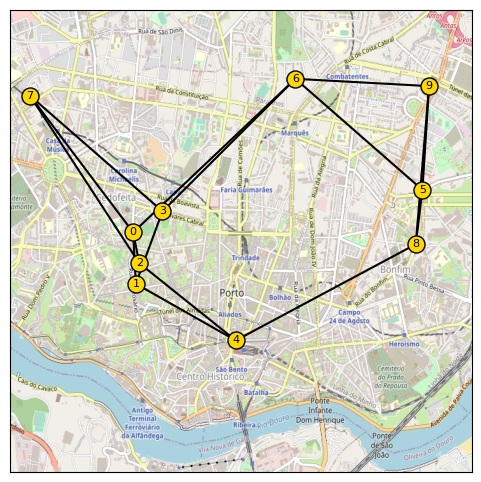

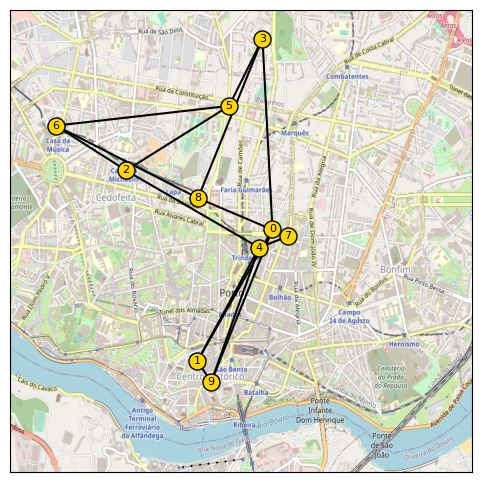

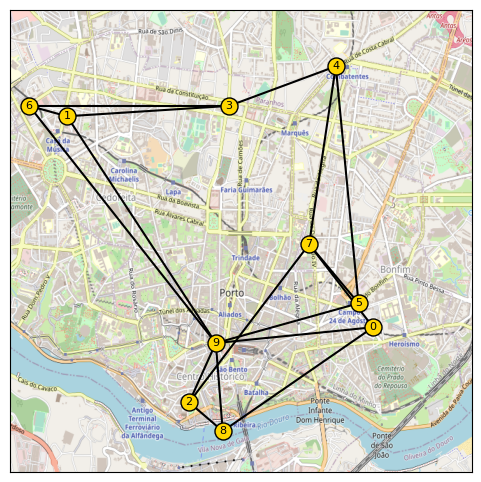

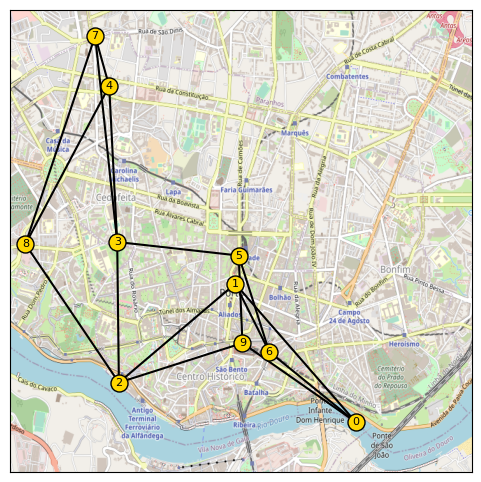

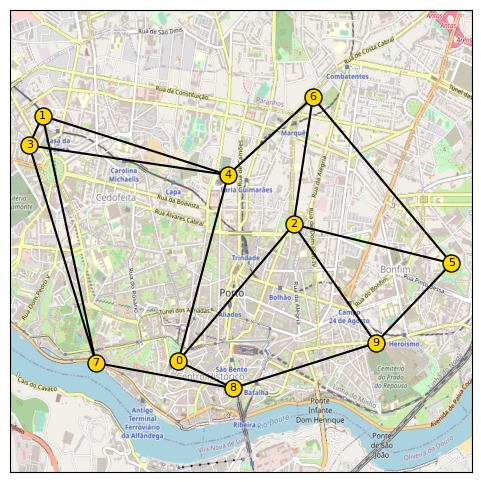

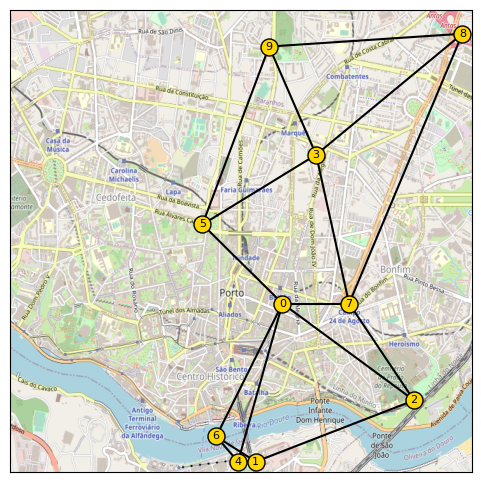

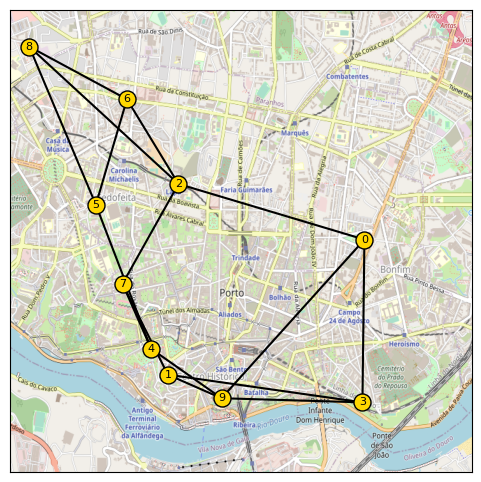

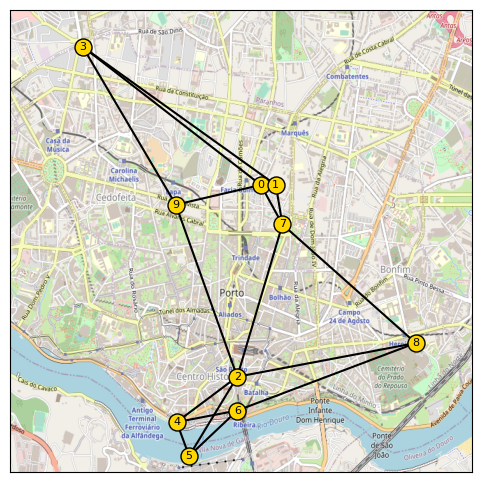

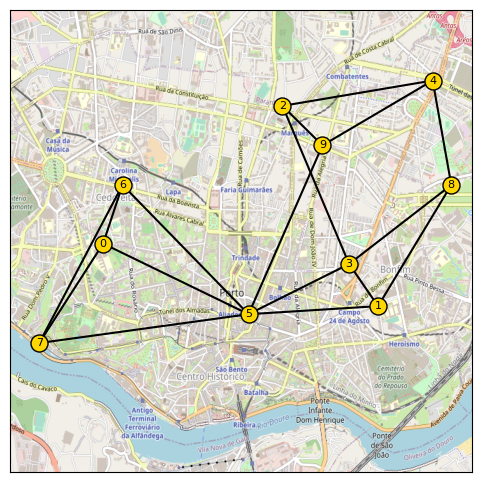

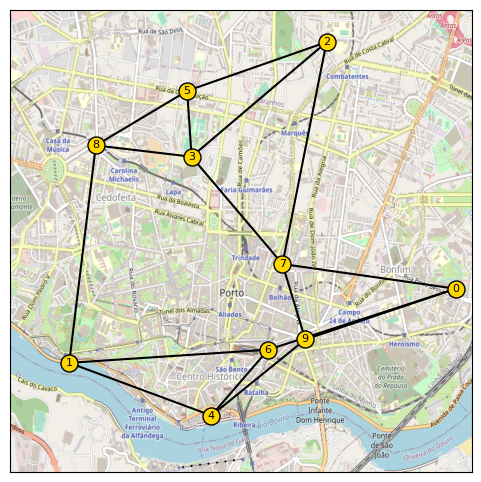

In [11]:
for i in range(n_simulations):
    folder_path = Path(f"../data/networks/{output}/{i}")
    folder_path.mkdir(parents=True, exist_ok=True)

    network, towers = build_network(cell_dataset, num_towers=n_nodes, k_edge_connectivity=k)

    plot_network(network, path=folder_path / "plot.jpg", towers=towers.values)
    nx.write_adjlist(network, folder_path / "adj_list.txt")
    towers.to_csv(folder_path / "towers.csv", index=False)

    print("Saved!")